# ECE 561 Variational Autoencoder
## By Utsav Negi 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, FashionMNIST
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random

## Aim: To design a variational autoencoder using CIFAR10 and Fashion MNIST dataset


Note: Try to run each VAE one at a time as the variable names are the same for both VAE

### 1) Variational autoencoder using CIFAR-10 datasets

#### Loading the Dataset

In [ ]:
#Batch Size Hyperparameter
BATCH_SIZE = 256
#Loading the training dataset and transforming the training images to tensors
train_set = CIFAR10('./dataset/train', train=True, download=True, transform=transforms.ToTensor())
#Creating a dataloader consisting of training data
trainLoader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
#Loading the testing dataset and transforming the training images to tensors
test_set = CIFAR10('./dataset/train', train=False, download=True, transform=transforms.ToTensor())
#Creating a dataloader consisting of testing data
testLoader = torch.utils.data.DataLoader(test_set,  shuffle=False, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


#### Sample Random Images

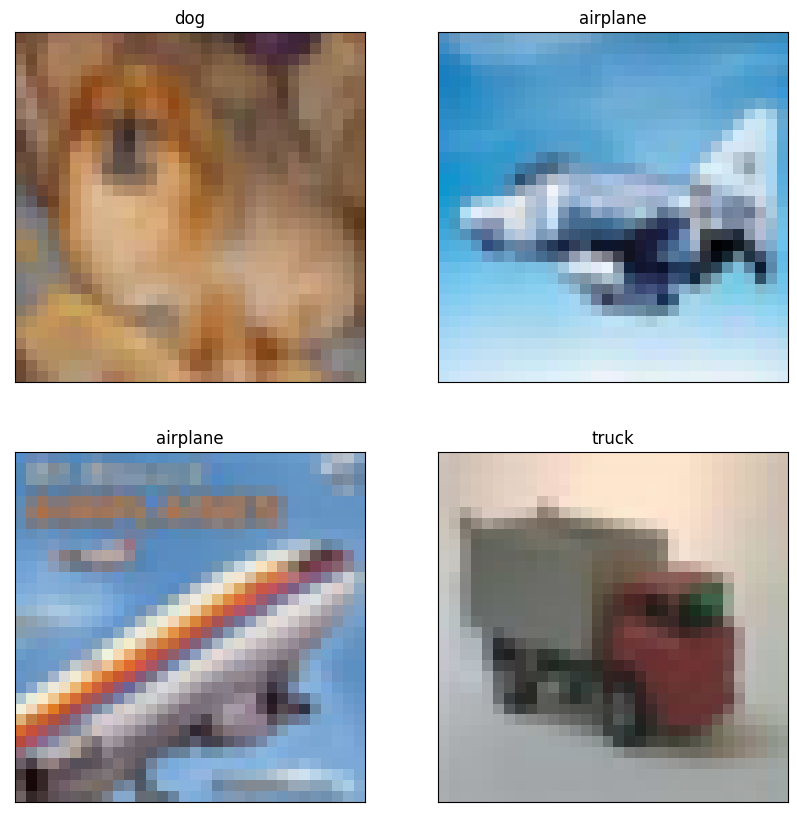

In [ ]:
#Printing some sample images

# taking the images data from training data
images = train_set.data
# taking image labels from the training data
classes = train_set.targets
# taking the list of possible classes
class_names = train_set.classes

# define row and column of figure
rows, columns = 2, 2
# take random image indexes
index = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[index]
# take labels for these images only
labels = [classes[i] for i in index]

# plot figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[labels[i-1]])
plt.show()

Note: the blurriness in the image is due to the transformation function while importing the dataset

#### Variational Autoencoder Model for CIFAR-10 Dataset

In [ ]:
# Class Object for CNN-based Variational Autoencoder
class VAE_CIFAR(nn.Module):
  def __init__(self, numChannels = 3, imgDim=40*22*22, zDim=256):                   #Settting the latent variable dimension as 256
    super(VAE_CIFAR, self).__init__()
    self.encoder_conv1 = nn.Conv2d(numChannels, 20, kernel_size=6)                  # 6x6x20 2D Convolution Filter A 
    self.encoder_conv2 = nn.Conv2d(20, 40, kernel_size=6)                           # 6x6x40 2D Convolution Filter B
    self.encoder_dense1 = nn.Linear(imgDim, zDim)                                   # Linear Layer to record the mean
    self.encoder_dense2 = nn.Linear(imgDim, zDim)                                   # Linear Layer to record the var

    self.decoder_dense1 = nn.Linear(zDim, imgDim)                                   # Linear Layer to decode the parameterized latent variable
    self.decoder_conv1 = nn.ConvTranspose2d(40, 20, kernel_size=6)                  # 6x6x20 2D Trans-Convolution Filter C
    self.decoder_conv2 = nn.ConvTranspose2d(20, numChannels, kernel_size=6)         # 6x6x3 2D Trans-Convolution Filter D

  def encoder(self,x):
    x = F.relu(self.encoder_conv1(x))                           #Using Filter A to convert 32 x 32 x 3 data to 27 x 27 x 20 and using ReLU activation function
    x = F.relu(self.encoder_conv2(x))                           #Using Filter B to convert 27 x 27 x 20 data to 22 x 22 x 40 data and using ReLU activation function
    x = x.view(-1, 40*22*22)                                    #Flatten all the channels into a single layer 
    mean = self.encoder_dense1(x)                               #Using a dense layer to record the mean
    log_variance = self.encoder_dense2(x)                       #Using a dense layer to record the variance
    return mean, log_variance                                   #Returning the mean and variance of latent variable

  def decoder(self, z):
    x = F.relu(self.decoder_dense1(z))                          #Using Linear layer to decode the latent variable
    x = x.view(-1, 40, 22, 22)                                  #Converting a single layer to multiple channels
    x = F.relu(self.decoder_conv1(x))                           #Using Filter C to convert 22 x 22 x 40 data to 27 x 27 x 20 data and using ReLU activation function
    x = torch.sigmoid(self.decoder_conv2(x))                    #Using Filter D to convert 27 x 27 x 20 data to 32 x 32 x 3 data and using ReLU activation function
    return x                                                    #Returning the generated image
  
  def norm_parameterize(self, mean, log_variance):
    #Mapping the mean and variance of latent variable to the a normal distribution curve
    return mean + (torch.exp(log_variance/2) * torch.randn_like(torch.exp(log_variance/2)))

  def forward(self, x):
    mean, log_variance = self.encoder(x)                       #Run the encoder
    z = self.norm_parameterize(mean, log_variance)             #Parameterize the mean and variance 
    out = self.decoder(z)                                      #Run the decoder 
    return out, mean, log_variance, z                          #Return the result, mean, log_variance, and z


Note: This steps takes time

#### Training the model

In [ ]:
learning_rate = 1e-3  #learning rate hyperparameter
num_epochs = 10       #number of epochs

model = VAE_CIFAR()   #creating a model object
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #using Adam Optimizer with model's parameters and learning rate

#Training loop
for epoch in range(num_epochs):
  for idx, data in enumerate(trainLoader,0):
    images, _ = data                                                              #Extracting the images data from the dataLoader
    out, mean, log_variance, z = model(images)                                    #Running the model
    kl_d = 0.5 * torch.sum(-1 - log_variance + mean.pow(2) + log_variance.exp())  #Calculating KL-Divergence
    loss = -F.binary_cross_entropy(out, images, reduction='sum') + kl_d            #Calculating ELBO using KL-Divergence and Cross-Entropy Loss
    optimizer.zero_grad()                                                         #Clearing the old gradients
    loss.backward()                                                               #Running the backpropogatation algorithm
    optimizer.step()                                                              #Updating the weights
  print('Epoch {}: Loss {}'.format(epoch+1, loss))

Epoch 1: Loss -12895848.0
Epoch 2: Loss -12782142.0
Epoch 3: Loss -12591602.0


#### Evaluating the model

In [ ]:
model.eval()                                                      #Setting the model to evaluation mode
with torch.no_grad():                                             #Turning off the gradient descent
    for data in random.sample(list(testLoader), 1):               #Using the images from testing dataloader
        imgs, _ = data                                            #Extracting the images from the dataLoader
        out, mu, logVAR, z = model(imgs)                          #Running the model with the testing inputs
        plt.subplot(131)                                          #Assigning a subplot for orignal image
        plt.imshow(np.transpose(imgs[0].numpy(), [1,2,0]))        #Showing the original image
        plt.xticks([])                                            #Turning off the x-axis
        plt.yticks([])                                            #Turning off the y-axis
        plt.title("Original Image")                               #Setting the title for subplot
        plt.subplot(132)                                          #Assign a subplot for Z
        plt.scatter(z[1], z[2])                                   #Plotting the first two components of Z
        plt.xlabel('First component')                             #Labelling the first component
        plt.ylabel('Second component')                            #Labelling the second component
        plt.title("Components of Z")                              #Setting the title for subplot
        outimg = np.transpose(out[0].numpy(), [1,2,0])            #Extracting a image from the output
        plt.subplot(133)                                          #Assigning a subplot for reconstructed image
        plt.imshow(np.squeeze(outimg))                            #Showing the decoded image
        plt.xticks([])                                            #Turning off the x-axis
        plt.yticks([])                                            #Turning off the y-axis
        plt.title('Reconstructed Image')                          #Setting the title for subplot
        #Subplot settings
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=1,hspace=1)
        break

Note: I tried to use the following methods, however each of the methods failed to reduce the error

- Batch Normalization : Increased the loss value upto million
- Increasing kernel size and strides : Increased the loss value in the range of 800000
- Using extra convolution layer: Similar results as of now
- Equating Zdim to the dimension of the image: Improvement can be seen, however it is against the objective
- Flatten the three channels and propogated to z using a dense layer: Worst results

Based on my observations, I believe that the CNN-based VAE is not able to regenerate image is due to lack of data in the image. The CIFAR uses 32 x 32 x 3, which I think is inadequate and the resultant image is generating pixels based on the mean and variance around selected pixels. Furthermore, the training time is too high, considering the fact that the resultant image is distant from the original image 

### 2) Variational autoencoder using Fashion-MNIST datasets

#### Loading the dataset

In [ ]:
#Batch Size Hyperparameter
BATCH_SIZE = 450
#Loading the training dataset and transforming the training images to tensors
train_set = FashionMNIST('./dataset/train', train=True, download=True, transform=transforms.ToTensor())
#Creating a dataloader consisting of training data
trainLoader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
#Loading the testing dataset and transforming the training images to tensors
test_set = FashionMNIST('./dataset/train', train=False, download=True, transform=transforms.ToTensor())
#Creating a dataloader consisting of testing data
testLoader = torch.utils.data.DataLoader(test_set,  shuffle=False, batch_size=BATCH_SIZE)

#### Sample Random Images

In [ ]:
#Printing some sample images

# taking the images data from training data
images = train_set.data
# taking image labels from the training data
classes = train_set.targets
# taking the list of possible classes
class_names = train_set.classes

# define row and column of figure
rows, columns = 2, 2
# take random image indexes
index = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[index]
# take labels for these images only
labels = [classes[i] for i in index]

# plot figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[labels[i-1]])
plt.show()

#### Variational Autoencoder Model for Fashion-MNIST

In [ ]:
class VAE_MNIST(nn.Module):
  def __init__(self, zDim=10):                           # Settting the latent variable dimension as 10
    super(VAE_MNIST, self).__init__()
    self.encoder_dense1 = nn.Linear(784, 900)            # Dense layer A: from 784 (28 x 28 x 1) input layer to 900 perceptrons layer
    self.encoder_dense2 = nn.Linear(900, 450)            # Dense layer B: from 900 perceptrons layer to 450 perceptrons layer
    self.encoder_dense3 = nn.Linear(450, 100)            # Dense layer C: from 450 perceptron layer to 100 perceptron layer
    self.encoder_dense4 = nn.Linear(100, zDim)           # Dense layer D:to record the mean 
    self.encoder_dense5 = nn.Linear(100, zDim)           # Dense layer E: to record the var

    self.decoder_dense1 = nn.Linear(zDim, 100)           # Dense Layer F: to decoder the parameterized latent variable
    self.decoder_dense2 = nn.Linear(100, 450)            # Dense layer G: from 100 perceptron layer to 450 perceptron layer
    self.decoder_dense3 = nn.Linear(450, 900)            # Dense layer H: from 450 perceptron layer to 900 perceptron layer
    self.decoder_dense4 = nn.Linear(900, 784)            # Dense layer I: from 900 perceptron layer to 784 perceptron layer

  def encoder(self,x):
    x = x.view(-1, 1, self.encoder_dense1.in_features)    # Converting the 28 x 28 x 1 layer to 784 x 1 layer
    x = F.relu(self.encoder_dense1(x))                    # Using Dense Layer A with ReLU Activation Function 
    x = F.relu(self.encoder_dense2(x))                    # Using Dense Layer B with ReLU Activation Function
    x = F.relu(self.encoder_dense3(x))                    # Using Dense Layer C with ReLU Activation Function
    mean = self.encoder_dense4(x)                         # Using Dense Layer D to record the mean
    log_variance = self.encoder_dense5(x)                 # Using Dense Layer E to record the variance
    return mean, log_variance

  def decoder(self, z):
    x = F.relu(self.decoder_dense1(z))                   # Using Dense Layer F with ReLU Activation Function
    x = F.relu(self.decoder_dense2(x))                   # Using Dense Layer G with ReLU Activation Function
    x = F.relu(self.decoder_dense3(x))                   # Using Dense Layer H with ReLU Activation Function
    x = torch.sigmoid(self.decoder_dense4(x))            # Using Dense Layer I with ReLU Activation Function
    x = x.view(-1, 1, 28, 28)                            # Converting 784 x 1 to 28 x 28 x 1 
    return x
  
  def norm_parameterize(self, mean, log_variance):
    #Mapping the mean and variance of latent variable to the a normal distribution curve
    return mean + (torch.exp(log_variance/2) * torch.randn_like(torch.exp(log_variance/2)))

  def forward(self, x):
    mean, log_variance = self.encoder(x)            #Run the encoder
    z = self.norm_parameterize(mean, log_variance)  #Parameterize the mean and variance 
    out = self.decoder(z)                           #Run the decoder
    return out, mean, log_variance, z               #Return the result, mean, log_variance, and z


#### Training the model

In [ ]:
learning_rate = 1e-3  #learning rate hyperparameter
num_epochs = 10       #number of epochs

model = VAE_MNIST()   #creating a model object
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #using Adam Optimizer with model's parameters and learning rate

#Training loop
for epoch in range(num_epochs):
  for idx, data in enumerate(trainLoader,0):
    images, _ = data                                                              #Extracting the images data from the dataLoader
    out, mean, log_variance, z = model(images)                                    #Running the model
    kl_d = 0.5 * torch.sum(-1 - log_variance + mean.pow(2) + log_variance.exp())  #Calculating KL-Divergence
    loss = F.binary_cross_entropy(out, images, reduction='sum') + kl_d            #Calculating ELBO using KL-Divergence and Cross-Entropy Loss
    optimizer.zero_grad()                                                         #Clearing the old gradients
    loss.backward()                                                               #Running the backpropogatation algorithm
    optimizer.step()                                                              #Updating the weights
  print('Epoch {}: Loss {}'.format(epoch+1, loss))

#### Evaluating the model

In [ ]:
model.eval()                                                      #Setting the model to evaluation mode
with torch.no_grad():                                             #Turning off the gradient descent
    for data in random.sample(list(testLoader), 1):               #Using the images from testing dataloader
        imgs, _ = data                                            #Extracting the images from the dataLoader
        out, mu, logVAR, z = model(imgs)                          #Running the model with the testing inputs
        plt.subplot(131)                                          #Assigning a subplot for orignal image
        plt.imshow(np.transpose(imgs[0].numpy(), [1,2,0]))        #Showing the original image
        plt.xticks([])                                            #Turning off the x-axis
        plt.yticks([])                                            #Turning off the y-axis
        plt.title("Original Image")                               #Setting the title for subplot
        plt.subplot(132)                                          #Assign a subplot for Z
        plt.scatter(z[1], z[2])                                   #Plotting the first two components of Z
        plt.xlabel('First component')                             #Labelling the first component
        plt.ylabel('Second component')                            #Labelling the second component
        plt.title("Components of Z")                              #Setting the title for subplot
        outimg = np.transpose(out[0].numpy(), [1,2,0])            #Extracting a image from the output
        plt.subplot(133)                                          #Assigning a subplot for reconstructed image
        plt.imshow(np.squeeze(outimg))                            #Showing the decoded image
        plt.xticks([])                                            #Turning off the x-axis
        plt.yticks([])                                            #Turning off the y-axis
        plt.title('Reconstructed Image')                          #Setting the title for subplot
        #Subplot settings
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=1,hspace=1)
        break

Note: Compared to the CIFAR-based VAE, the Fashion-MNIST VAE worked pretty well. The main reason is because the data had a single channel, which was pretty adequate. In addition, the image can be flatten to a dense layer, which can be propogated using a dense layer, rather than a convolution filter.